# Sections
1. Univariate properties
2. Spatial properties
3. Multivatiate properties

In [810]:
import os
import numpy as np
import wandb
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from hazardGAN import DCGAN, fig_utils, utils
from importlib import reload
import wandb

plt.rcParams["font.family"] = "monospace"
plot_kwargs = {'dpi': 500, 'bbox_inches': 'tight'}
hist_kwargs = {'density': True, 'color': 'lightgrey', 'alpha': 0.6, 'edgecolor': 'k'}

wd = "/Users/alison/Documents/DPhil/multivariate/hazardGAN"

RUNNAME = 'stellar-dawn-128' #'solar-wind-126' ##'icy-frog-125' # 'solar-sweep-1' # 'leafy-plant-114'
evt_type = 'bm'
pot = (evt_type == "pot")

os.chdir(os.path.join(wd, 'saved-models', evt_type, RUNNAME))
paddings = tf.constant([[0,0], [1,1], [1,1], [0,0]])

cmaps = ["YlOrRd", "PuBu", "YlGnBu"]
figdir = "/Users/alison/Documents/DPhil/multivariate/cycloneGAN/figures/results"

In [811]:
wandb.init(project='test', mode='disabled')
dcgan = DCGAN(wandb.config, nchannels=3)
dcgan.generator.load_weights(os.path.join(wd, 'saved-models', evt_type, RUNNAME, f'generator_weights'))
dcgan.discriminator.load_weights(os.path.join(wd, 'saved-models', evt_type, RUNNAME, f'discriminator_weights'))

dcgan.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_28 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_27 (Dense)            (None, 25600)             2585600   
                                                                 
 reshape_41 (Reshape)        (None, 5, 5, 1024)        0         
                                                                 
 batch_normalization_67 (Bat  (None, 5, 5, 1024)       4096      
 chNormalization)                                                
                                                                 
 leaky_re_lu_81 (LeakyReLU)  (None, 5, 5, 1024)        0         
                                                                 
 dropout_81 (Dropout)        (None, 5, 5, 1024)        0         
                                                         

# 1. Marginal properties

In [813]:
reload(utils)
gan = dcgan(1000)
train, _, params, images, thresholds = utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", train_size=2000, evt_type=evt_type)
test, test_images, _ = utils.load_test_data("/Users/alison/Documents/DPhil/multivariate", evt_type=evt_type)

train = utils.tf_unpad(train, paddings).numpy()
test = utils.tf_unpad(test, paddings).numpy()
gan = utils.tf_unpad(gan, paddings).numpy()

if pot:
    f_thresholds = utils.interpolate_thresholds(thresholds, images, train)

n, h, w, c = train.shape

In [814]:
reload(utils)

train_inv = utils.inv_probability_integral_transform(train, images, train, params, evt_type, thresholds)
gan_inv = utils.inv_probability_integral_transform(gan, images, train, params, evt_type, thresholds)

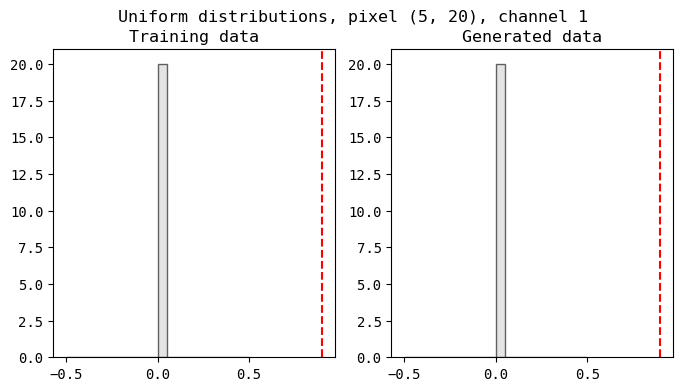

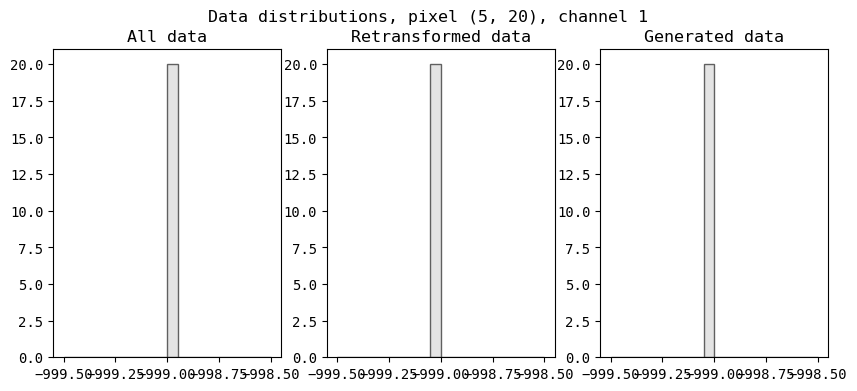

In [815]:
i, j, c = (np.random.randint(0, 18), np.random.randint(0, 22), 1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
_, bins, *_ = axs[0].hist(train[..., i, j, c].ravel(), bins=20, **hist_kwargs);
axs[1].hist(gan[..., i, j, c].ravel(), bins=bins, **hist_kwargs);

axs[0].set_title('Training data')
axs[1].set_title('Generated data')

for ax in axs:
    ax.axvline(0.9, color='red', linestyle='dashed')

fig.suptitle(f'Uniform distributions, pixel ({i}, {j}), channel {c}');


# original marginals
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

_, bins, *_ = axs[0].hist(images[..., i, j, c], bins=20, **hist_kwargs)
axs[1].hist(train_inv[..., i, j, c], bins=bins, **hist_kwargs)
axs[2].hist(gan_inv[..., i, j, c], bins=bins, **hist_kwargs)

if pot:
    for ax in axs:
        ax.axvline(thresholds[i, j, c], color='red', linestyle='dashed')

axs[0].set_title('All data')
axs[1].set_title('Retransformed data')
axs[2].set_title('Generated data')

fig.suptitle(f'Data distributions, pixel ({i}, {j}), channel {c}');

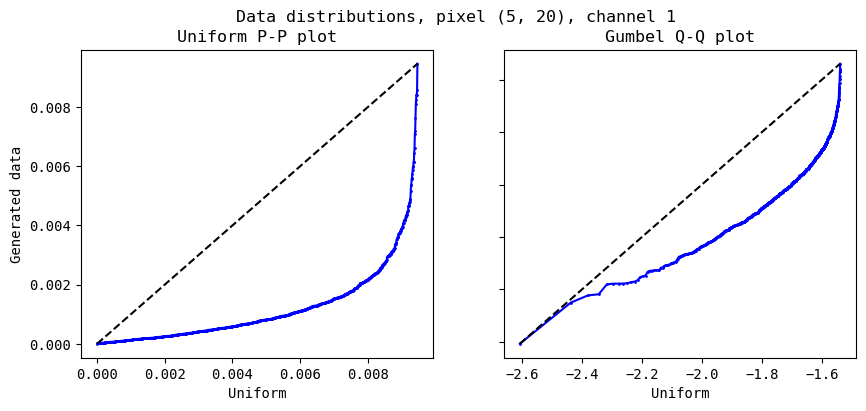

In [816]:
# QQ plots

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

y = sorted(gan[..., i, j, c].ravel())
x = np.linspace(min(y), max(y), len(y))

axs[0].plot(x, y, '-ob', markersize=1)
axs[0].plot(x, x, '--k')
axs[0].set_title('Uniform P-P plot')

y_gumbel = -np.log(-np.log(y))
x_gumbel = -np.log(-np.log(x))


axs[1].plot(x_gumbel, y_gumbel, '-ob', markersize=1)
axs[1].plot(x_gumbel, x_gumbel, '--k')
axs[1].set_title('Gumbel Q-Q plot')

for ax in axs:
    ax.set_xlabel('Uniform')
    ax.set_ylabel('Generated data')
    ax.label_outer();
    
    
fig.suptitle(f'Data distributions, pixel ({i}, {j}), channel {c}');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


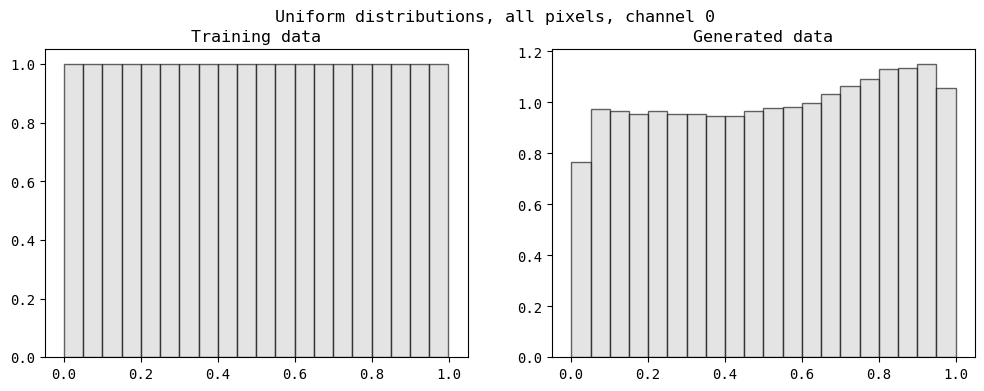

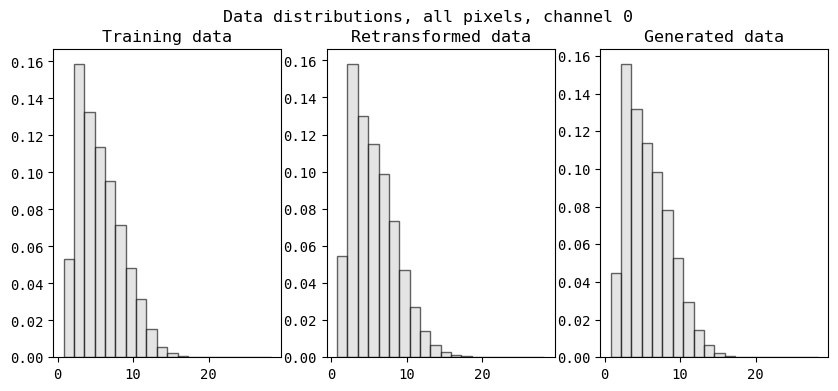

In [817]:
c = 0

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
_, bins, *_ = axs[0].hist(train[..., c].ravel(), bins=20, **hist_kwargs);
axs[1].hist(gan[..., c].ravel(), bins=bins, **hist_kwargs);

axs[0].set_title('Training data')
axs[1].set_title('Generated data')

# for ax in axs:
    # ax.axvline(0.9, color='red', linestyle='dashed')
#     minthresh = f_thresholds[..., c].ravel().min()
#     maxthresh = f_thresholds[..., c].ravel().max()
#     ax.axvspan(minthresh, maxthresh, alpha=0.5, color='red', label='Thresholds')
#     ax.axvline(minthresh, color='red', linestyle='--', linewidth=1)
#     ax.axvline(maxthresh, color='red', linestyle='--', linewidth=1)

ax.legend(loc='upper right')
fig.suptitle(f'Uniform distributions, all pixels, channel {c}');



# for transformed distributions
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

_, bins, *_ = axs[0].hist(images[..., c].ravel(), bins=20, **hist_kwargs)
axs[1].hist(train_inv[..., c].ravel(), bins=bins, **hist_kwargs)
axs[2].hist(gan_inv[..., c].ravel(), bins=bins, **hist_kwargs)

axs[0].set_title('Training data')
axs[1].set_title('Retransformed data')
axs[2].set_title('Generated data')

fig.suptitle(f'Data distributions, all pixels, channel {c}');

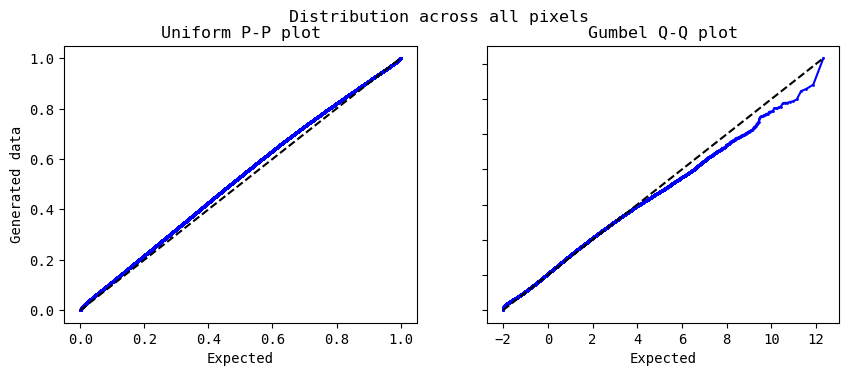

In [818]:
# QQ plots
fig, axs = plt.subplots(1, 2, figsize=(10, 3.6))

y = sorted(gan[..., c].ravel())
x = np.linspace(min(y), max(y), len(y))

axs[0].plot(x, y, '-ob', markersize=1)
axs[0].plot(x, x, '--k')
axs[0].set_title('Uniform P-P plot')

y_gumbel = -np.log(-np.log(y))
x_gumbel = -np.log(-np.log(x))


axs[1].plot(x_gumbel, y_gumbel, '-ob', markersize=1)
axs[1].plot(x_gumbel, x_gumbel, '--k')
axs[1].set_title('Gumbel Q-Q plot')

for ax in axs:
    ax.set_xlabel('Expected')
    ax.set_ylabel('Generated data')
    ax.label_outer();
    
fig.suptitle('Distribution across all pixels');

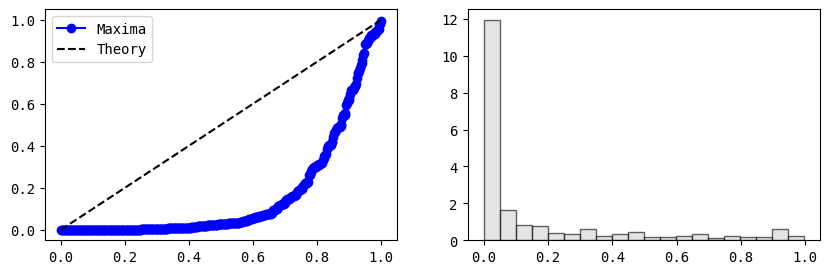

In [819]:
# looking over all channels as before
channel = 0
n, h, w, c = gan.shape

y = gan.reshape(n, h * w, c)[..., channel]
y_maxima = np.max(y, axis=0)
f_maxima = y_maxima ** n

x = np.linspace(0, 1, h * w)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax[0].plot(x, sorted(f_maxima), '-o', color='blue', label='Maxima')
ax[0].plot(x, x, '--k', label='Theory')
ax[0].legend()

ax[1].hist(f_maxima, bins=20, **hist_kwargs);

# 2. Spatial Properties

In [820]:
# load data fresh
reload(utils)
gan = dcgan(1000)
train, _, params, images, thresholds = utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", train_size=1000, evt_type=evt_type)
train_all, _, _, images_all, *_ = utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", train_size=2000, evt_type=evt_type)
test, *_ = utils.load_test_data("/Users/alison/Documents/DPhil/multivariate", evt_type=evt_type)

train = utils.tf_unpad(train, paddings).numpy()
test = utils.tf_unpad(test, paddings).numpy()
gan = utils.tf_unpad(gan, paddings).numpy()
gan = utils.gaussian_blur(gan, kernel_size=2, sigma=0.5).numpy()  # smoothing filter

if pot:
    f_thresholds = utils.interpolate_thresholds(thresholds, images, train)

train_inv = utils.inv_probability_integral_transform(train, images, train, params, evt_type, thresholds)
test_inv = utils.inv_probability_integral_transform(test, images, train, params, evt_type, thresholds)
gan_inv = utils.inv_probability_integral_transform(gan, images, train, params, evt_type, thresholds)    

n, h, w, c = train.shape

help(viz_utils.compare_ecs_plot)

Help on function compare_ecs_plot in module evtGAN.viz_utils:

compare_ecs_plot(train_marginals, test_marginals, fake_marginals, x, y, params=None, thresh=None, channel=0, cmap='cividis', inverse_transform=True)



In [821]:
def get_all_correlations(x):
    n, h, w = x.shape
    k = h * w
    x = x.reshape(n, k)
    corrs = np.ones([k, k])
    for i in range(k):
        for j in range(i - 1):
            corr = np.corrcoef(x[:, i], x[:, j])[0, 1]
            corrs[i, j] = corr
            corrs[j, i] = corr
    return corrs


def get_all_extremal_corrs(x):
    n, h, w = x.shape
    k = h * w
    x = x.reshape(n, k)
    corrs = np.ones([k, k])
    for i in range(k):
        for j in range(i - 1):
            corr = [*utils.get_extremal_correlations(x[..., channel], [i, j]).values()][0]
            print("({},{}): {}".format(i, j, corr))
            corrs[i, j] = corr
            corrs[j, i] = corr
    return corrs

In [822]:
def add_colorbar(im, ax, pad=0.05):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=pad)
    fig.colorbar(im, cax=cax, orientation='vertical')

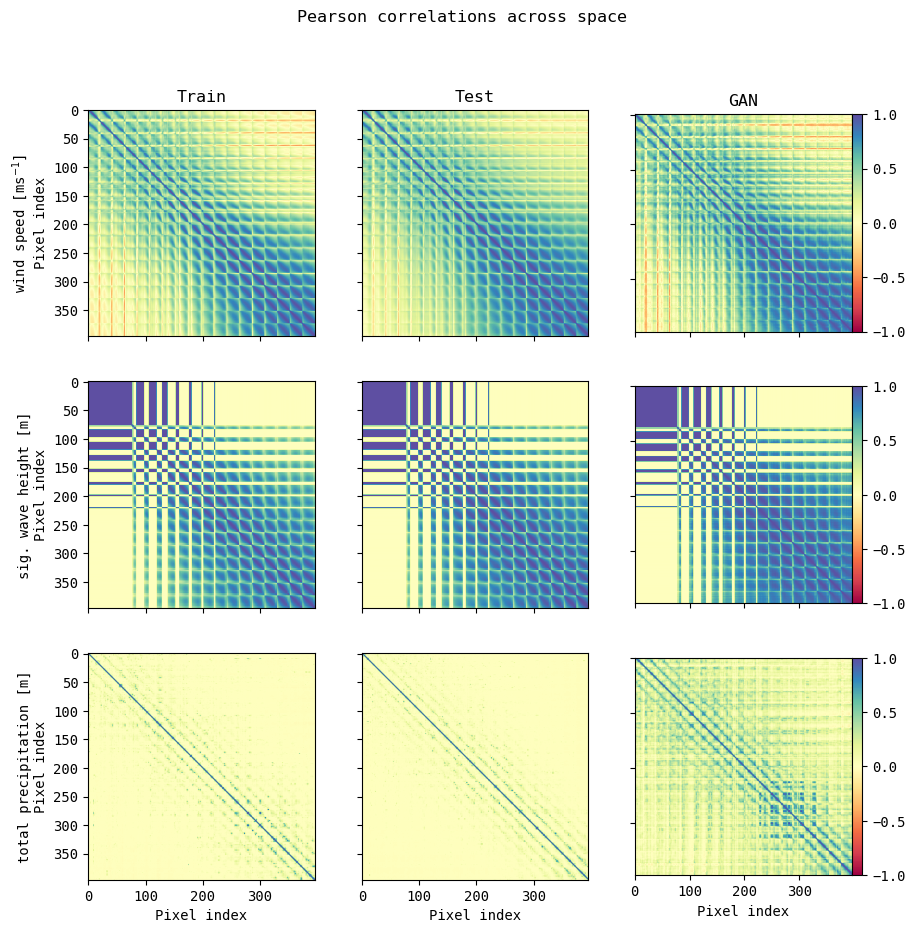

In [823]:
fig, axs = plt.subplots(3, 3, figsize=(10, 10))
for channel in range(3):
    corrs_train = get_all_correlations(train_inv[..., channel])
    corrs_test = get_all_correlations(test_inv[..., channel])
    corrs_gan = get_all_correlations(gan_inv[..., channel])

    ax = axs[channel, :]
    im = ax[0].imshow(corrs_train, vmin=-1, vmax=1, cmap='Spectral')
    ax[1].imshow(corrs_test, vmin=-1, vmax=1, cmap='Spectral')
    ax[2].imshow(corrs_gan, vmin=-1, vmax=1, cmap='Spectral')
    ax[0].set_ylabel("{}\nPixel index".format(viz_utils.channel_labels[channel]))

    add_colorbar(im, ax[2], pad=0)

axs[0, 0].set_title('Train')
axs[0, 1].set_title('Test')
axs[0, 2].set_title('GAN')

for ax in axs.ravel():
    ax.set_xlabel('Pixel index')
    ax.label_outer()
    
fig.suptitle('Pearson correlations across space')

if False:
    fig.savefig(os.path.join(figdir, f'spatial_corrs.png'), dpi=300, bbox_inches='tight');

ValueError: array must not contain infs or NaNs

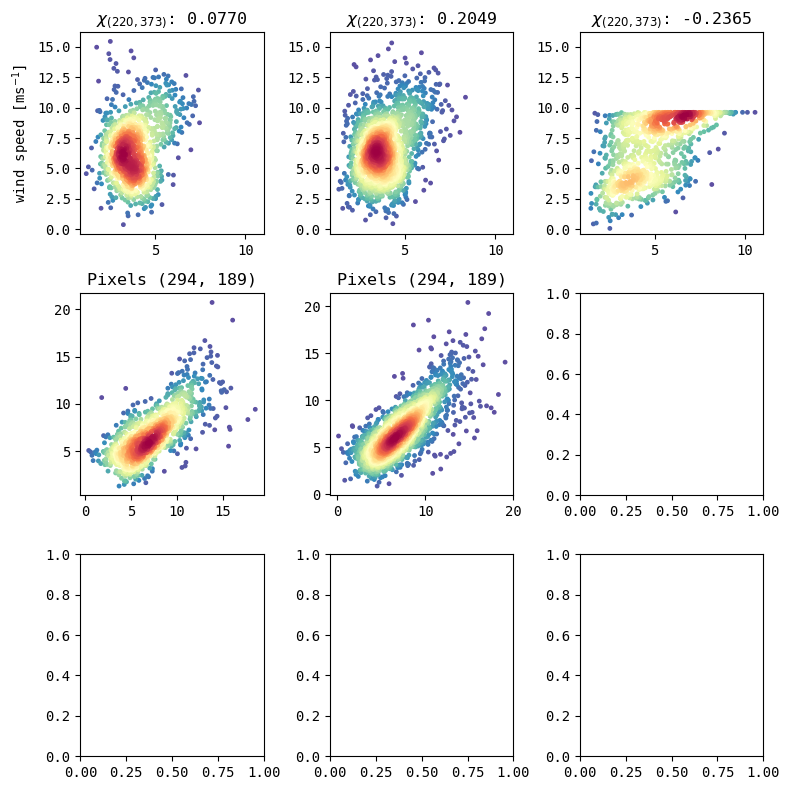

In [806]:
reload(viz_utils)
channel = 0
fig = viz_utils.compare_tails_plot(train, test, gan, images, train, params=params, thresh=thresholds, channel=channel, cmap='Spectral_r',
                                   evt_type=evt_type, figsize=(8, 8), s=6)


if False:
    fig.savefig(os.path.join(figdir, f'pixel_scatterplots_{viz_utils.channel_labels[channel]}.png'), dpi=300, bbox_inches='tight')

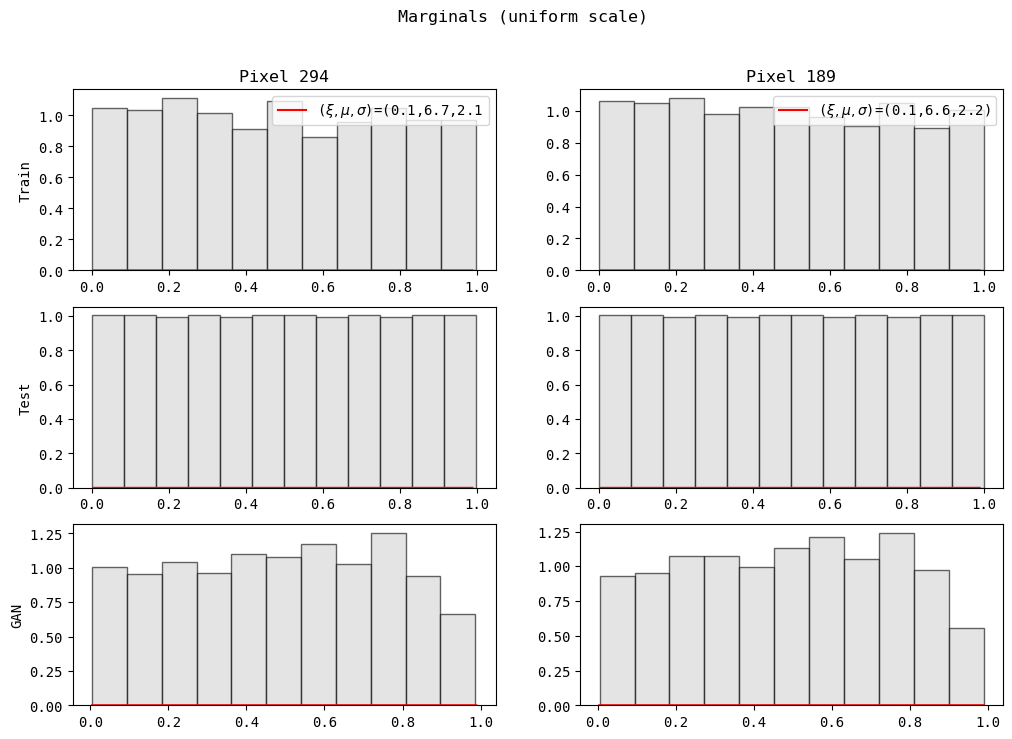

In [398]:
# explore the distributions of any funny looking pixels
#n e.g. sometimes scale parameter is the issue, not the shape parameter
if pot:
    from scipy.stats import genpareto as model
else:
    from scipy.stats import genextreme as model

a, b = 332, 311
a = utils.translate_indices(a)
b = utils.translate_indices(b)

params_a = params[a[0], a[1], :, channel]
params_b = params[b[0], b[1], :, channel]

if pot:
    thresh_a = thresholds[a[0], a[1], channel]
    thresh_b = thresholds[b[0], b[1], channel]

# data
train_a = train[:, a[0], a[1], channel]
train_b = train[:, b[0], b[1], channel]
if pot:
    train_a = train_a[train_a > thresh_a]
    train_b = train_b[train_b > thresh_b]

test_train_a = test[:, a[0], a[1], channel]
test_train_b = test[:, b[0], b[1], channel]
if pot:
    test_train_a = test_train_a[test_train_a > thresh_a]
    test_train_b = test_train_b[test_train_b > thresh_b]

gan_a = gan[:, a[0], a[1], channel]
gan_b = gan[:, b[0], b[1], channel]
if pot:
    gan_a = gan_a[gan_a > thresh_a]
    gan_b = gan_b[gan_b > thresh_b]

# paretio fits
if pot:
    mins = [thresh_a, thresh_b]
else:
    mins = [min(gan_a), min(gan_b)]
x = np.linspace(min(mins), max(max(gan_a), max(gan_b)), 100)
fit_a = model.pdf(x, *params_a)
fit_b = model.pdf(x, *params_b)

# plot
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs[0, 0].hist(train_a, bins='auto', **hist_kwargs)
axs[0, 1].hist(train_b, bins='auto', **hist_kwargs);
axs[1, 0].hist(test_train_a, bins='auto', **hist_kwargs)
axs[1, 1].hist(test_train_b, bins='auto', **hist_kwargs);
axs[2, 0].hist(gan_a, bins='auto', **hist_kwargs)
axs[2, 1].hist(gan_b, bins='auto', **hist_kwargs);

axs[0, 0].plot(x, fit_a, color='red', label=r'($\xi, \mu, \sigma$)=({:.1f},{:.1f},{:.1f}'.format(*params_a))
axs[0, 1].plot(x, fit_b, color='red', label=r'($\xi, \mu, \sigma$)=({:.1f},{:.1f},{:.1f})'.format(*params_b))
axs[1, 0].plot(x, fit_a, color='red')
axs[1, 1].plot(x, fit_b, color='red')
axs[2, 0].plot(x, fit_a, color='red')
axs[2, 1].plot(x, fit_b, color='red')
               
axs[0, 0].set_title('Pixel 294');
axs[0, 1].set_title('Pixel 189');

axs[0, 0].set_ylabel('Train')
axs[1, 0].set_ylabel('Test')
axs[2, 0].set_ylabel('GAN')

axs[0, 0].legend()
axs[0, 1].legend();

fig.suptitle('Marginals (uniform scale)');

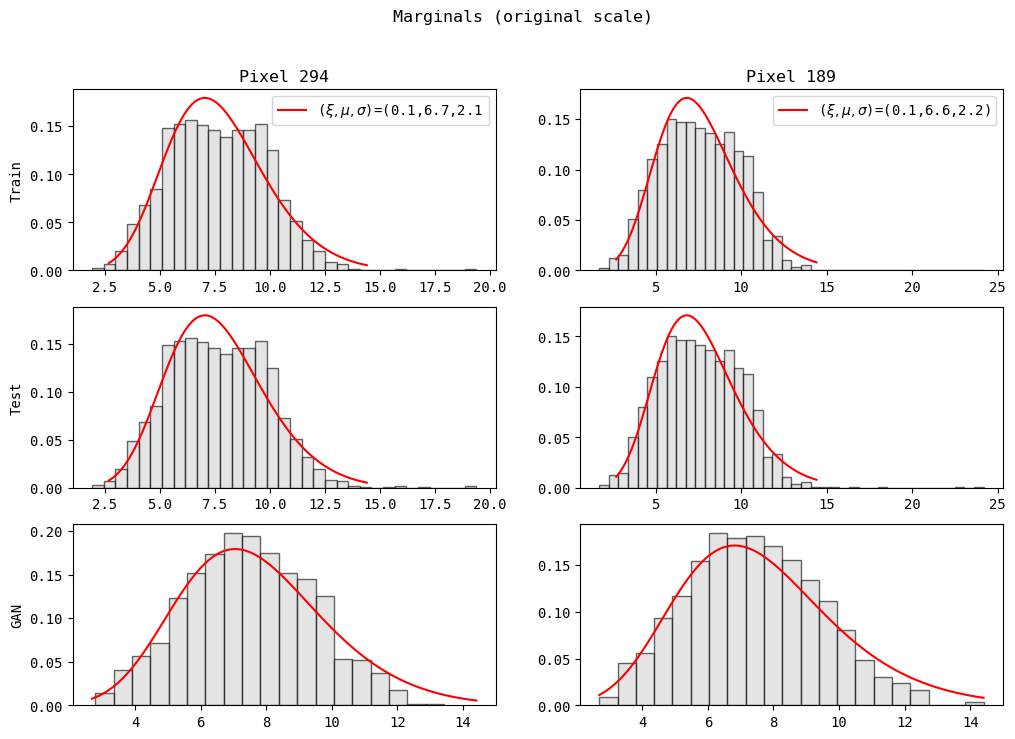

In [395]:
# explore the distributions of any funny looking pixels
#n e.g. sometimes scale parameter is the issue, not the shape parameter
if pot:
    from scipy.stats import genpareto as model
else:
    from scipy.stats import genextreme as model

a, b = 332, 311
a = utils.translate_indices(a)
b = utils.translate_indices(b)

params_a = params[a[0], a[1], :, channel]
params_b = params[b[0], b[1], :, channel]

if pot:
    thresh_a = thresholds[a[0], a[1], channel]
    thresh_b = thresholds[b[0], b[1], channel]

# data
images_a = images_all[:, a[0], a[1], channel]
images_b = images_all[:, b[0], b[1], channel]
if pot:
    images_a = images_a[images_a > thresh_a]
    images_b = images_b[images_b > thresh_b]

test_images_a = images_all[:, a[0], a[1], channel]
test_images_b = images_all[:, b[0], b[1], channel]
if pot:
    test_images_a = test_images_a[test_images_a > thresh_a]
    test_images_b = test_images_b[test_images_b > thresh_b]

gan_inv_a = gan_inv[:, a[0], a[1], channel]
gan_inv_b = gan_inv[:, b[0], b[1], channel]
if pot:
    gan_inv_a = gan_inv_a[gan_inv_a > thresh_a]
    gan_inv_b = gan_inv_b[gan_inv_b > thresh_b]

# paretio fits
if pot:
    mins = [thresh_a, thresh_b]
else:
    mins = [min(gan_inv_a), min(gan_inv_b)]
x = np.linspace(min(mins), max(max(gan_inv_a), max(gan_inv_b)), 100)
fit_a = model.pdf(x, *params_a)
fit_b = model.pdf(x, *params_b)

# plot
fig, axs = plt.subplots(3, 2, figsize=(12, 8))
axs[0, 0].hist(images_a, bins='auto', **hist_kwargs)
axs[0, 1].hist(images_b, bins='auto', **hist_kwargs);
axs[1, 0].hist(test_images_a, bins='auto', **hist_kwargs)
axs[1, 1].hist(test_images_b, bins='auto', **hist_kwargs);
axs[2, 0].hist(gan_inv_a, bins='auto', **hist_kwargs)
axs[2, 1].hist(gan_inv_b, bins='auto', **hist_kwargs);

axs[0, 0].plot(x, fit_a, color='red', label=r'($\xi, \mu, \sigma$)=({:.1f},{:.1f},{:.1f}'.format(*params_a))
axs[0, 1].plot(x, fit_b, color='red', label=r'($\xi, \mu, \sigma$)=({:.1f},{:.1f},{:.1f})'.format(*params_b))
axs[1, 0].plot(x, fit_a, color='red')
axs[1, 1].plot(x, fit_b, color='red')
axs[2, 0].plot(x, fit_a, color='red')
axs[2, 1].plot(x, fit_b, color='red')
               
axs[0, 0].set_title('Pixel 294');
axs[0, 1].set_title('Pixel 189');

axs[0, 0].set_ylabel('Train')
axs[1, 0].set_ylabel('Test')
axs[2, 0].set_ylabel('GAN')

axs[0, 0].legend()
axs[0, 1].legend();

fig.suptitle('Marginals (original scale)');

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


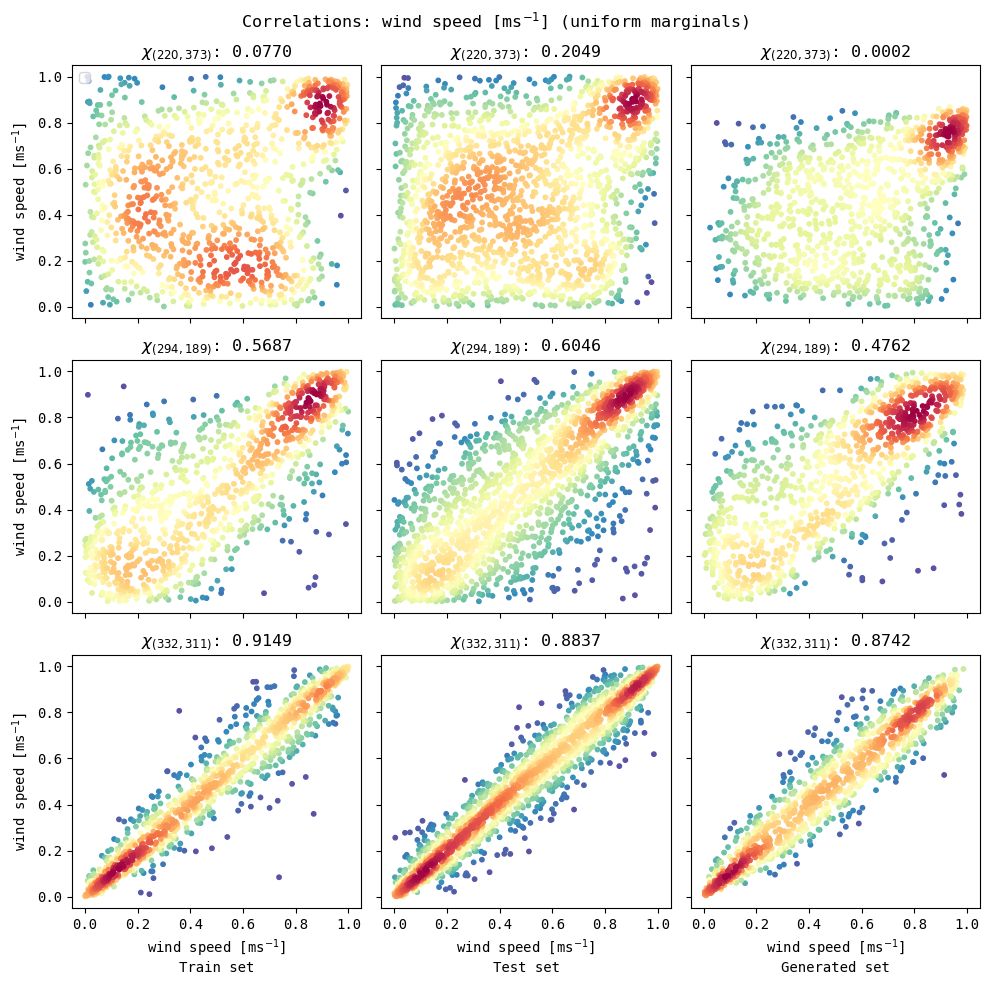

In [377]:
channel = 0
reload(viz_utils)
fig = viz_utils.compare_tails_plot(train, test, gan, images, train, params=params, thresh=thresholds, channel=channel, cmap='Spectral_r', inverse_transform=False, evt_type=evt_type)

#fig.savefig(os.path.join(figdir, 'pixel_scatterplots_uniform.png'), dpi=300, bbox_inches='tight')

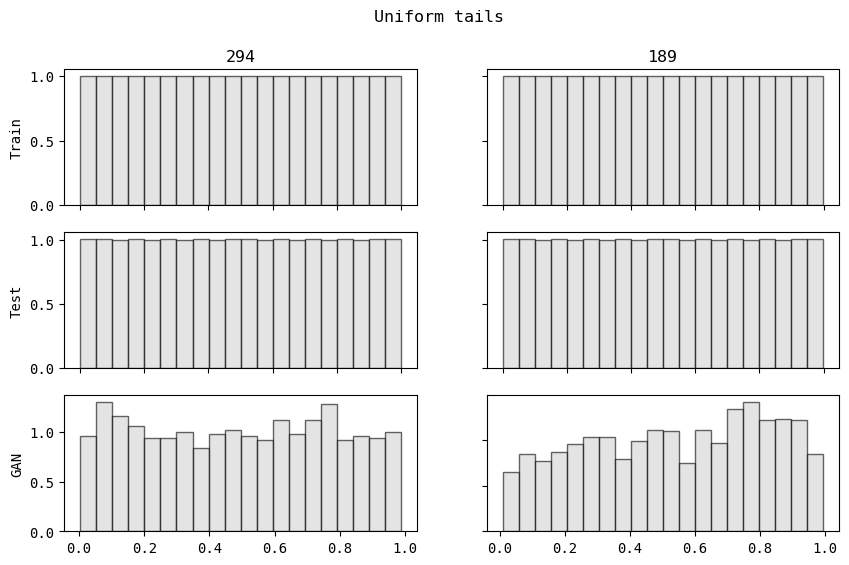

In [378]:
fig, axs = plt.subplots(3, 2, figsize=(10, 6))

if pot:
    f_thresh_a = f_thresholds[a[0], a[1], channel]
    f_thresh_b = f_thresholds[b[0], b[1], channel]

# plot training data
train_a = train_all[:, a[0], a[1], channel]
train_b = train_all[:, b[0], b[1], channel]

if pot:
    train_a = train_a[train_a > f_thresh_a]
    train_b = train_b[train_b > f_thresh_b]

axs[0, 0].hist(train_a, bins=20, **hist_kwargs)
axs[0, 1].hist(train_b, bins=20,  **hist_kwargs);

axs[0, 0].set_title(294)
axs[0, 1].set_title(189)

# plot test data
test_a = test[:, a[0], a[1], channel]
test_b = test[:, b[0], b[1], channel]

if pot:
    test_a = test_a[test_a > f_thresh_a]
    test_b = test_b[test_b > f_thresh_b]

axs[1, 0].hist(test_a, bins=20, **hist_kwargs)
axs[1, 1].hist(test_b, bins=20,  **hist_kwargs);

# plot generated data
gan_a = gan[:, a[0], a[1], channel]
gan_b = gan[:, b[0], b[1], channel]
if pot:
    gan_a = gan_a[gan_a > f_thresh_a]
    gan_b = gan_b[gan_b > f_thresh_b]

axs[2, 0].hist(gan_a, bins=20, **hist_kwargs)
axs[2, 1].hist(gan_b, bins=20,  **hist_kwargs);

for ax in axs.ravel():
    ax.label_outer()
    
axs[0, 0].set_ylabel('Train')
axs[1, 0].set_ylabel('Test')
axs[2, 0].set_ylabel('GAN');

fig.suptitle('Uniform tails');

# Correlations (inter-channel)

In [ ]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def get_channel_corrs(x, channel0, channel1):
    n, h, w, c = x.shape
    
    corrs = np.ones([h, w])
    for i in range(h):
        for j in range(w):
            corr = np.corrcoef(x[:, i, j, channel0], x[:, i, j, channel1])[0, 1]
            corrs[i, j] = corr
    return corrs

c0, c1 = 0, 2

for c0, c1 in [[0, 1], [0, 2], [1, 2]]:

    train_corrs = get_channel_corrs(train, c0, c1)
    test_corrs = get_channel_corrs(test, c0, c1)
    gan_corrs = get_channel_corrs(gan, c0, c1)
    
    mask = np.ma.masked_invalid(train_corrs)
    gan_corrs[mask.mask] = np.nan

    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    im = ax[0].imshow(train_corrs, vmin=-1, vmax=1, cmap="Spectral")
    ax[1].imshow(test_corrs, vmin=-1, vmax=1, cmap="Spectral")
    ax[2].imshow(gan_corrs, vmin=-1, vmax=1, cmap="Spectral")
    
    divider = make_axes_locatable(ax[2])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    ax[0].set_title("Training")
    ax[1].set_title("Test")
    ax[2].set_title("GAN")
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

    fig.suptitle("Correlation between {} and {}".format(viz_utils.channel_labels[c0], viz_utils.channel_labels[c1]))

In [790]:
# now do the same for extremals (but in 3d because you can!)
def get_channel_ext_coefs(x):
    n, h, w, c = x.shape
    excoefs = utils.get_extremal_coeffs_nd(x, [*range(h * w)])
    excoefs = np.array([*excoefs.values()]).reshape(h, w)
    return excoefs

# correlations for all three variables
excoefs_train = get_channel_ext_coefs(train)
excoefs_test = get_channel_ext_coefs(test)
excoefs_gan = get_channel_ext_coefs(gan)

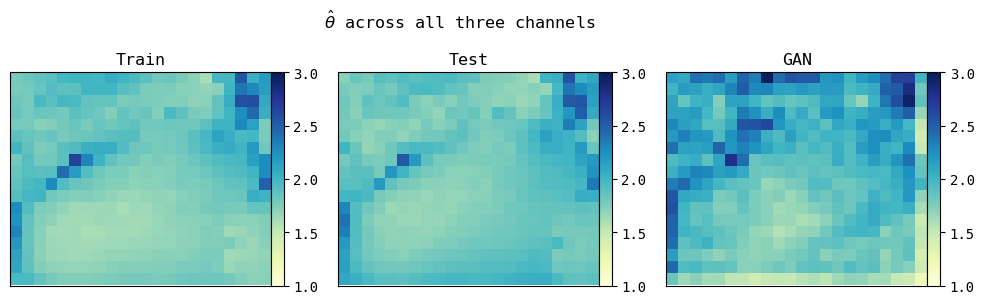

In [791]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))

im = ax[0].imshow(excoefs_train, cmap="YlGnBu", vmin=1, vmax=3)
im = ax[1].imshow(excoefs_test, cmap="YlGnBu", vmin=1, vmax=3)
im = ax[2].imshow(excoefs_gan, cmap="YlGnBu", vmin=1, vmax=3)

add_colorbar(im, ax[0], pad=0)
add_colorbar(im, ax[1], pad=0)
add_colorbar(im, ax[2], pad=0)

for a in ax:
    a.set_yticks([])
    a.set_xticks([])
    
ax[0].set_title('Train')
ax[1].set_title('Test')
ax[2].set_title('GAN');

fig.suptitle(r'$\hat \theta$ across all three channels');


plt.scatter(test_corrs, gan_corrs);
fig.savefig(os.path.join(figdir, f'ecorr_multichannel_heatmaps.png'), dpi=300, bbox_inches='tight');

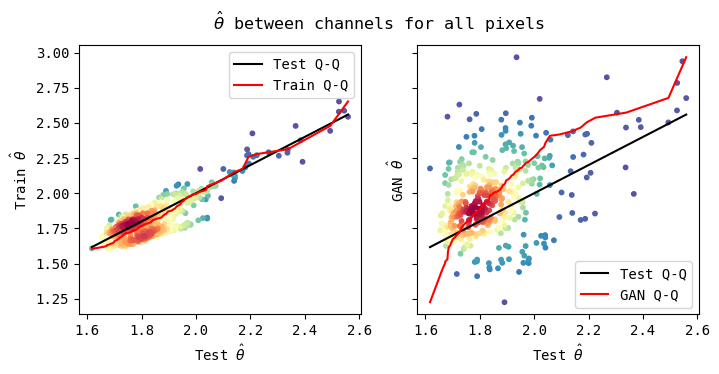

In [666]:
reload(utils)
fig, axs = plt.subplots(1, 2, figsize=(8, 3.5))

viz_utils.scatter_density2(excoefs_test.ravel(), excoefs_train.ravel(), axs[0], cmap='Spectral_r')
viz_utils.scatter_density2(excoefs_test.ravel(), excoefs_gan.ravel(), axs[1], cmap='Spectral_r')

quantiles = np.linspace(0, 1, 100)

for ax in axs:
    ax.plot(np.quantile(sorted(excoefs_test.ravel()), quantiles),
            np.quantile(sorted(excoefs_test.ravel()), quantiles),
            'k', label="Test Q-Q")
    
axs[0].plot(np.quantile(sorted(excoefs_test.ravel()), quantiles),
            np.quantile(sorted(excoefs_train.ravel()), quantiles),
            'r', label="Train Q-Q")

axs[1].plot(np.quantile(sorted(excoefs_test.ravel()), quantiles),
            np.quantile(sorted(excoefs_gan.ravel()), quantiles),
            'r', label="GAN Q-Q")

for ax in axs:
    ax.set_xlim(axs[1].get_xlim())
    ax.set_ylim(axs[1].get_ylim()) 
    ax.set_xlabel(r'Test $\hat \theta$')
    ax.legend()
    ax.label_outer()
    
# axs[1].set_yticks([])

axs[0].set_ylabel(r'Train $\hat \theta$')
axs[1].set_ylabel(r'GAN $\hat \theta$');
fig.suptitle(r'$\hat \theta$ between channels for all pixels');

fig.savefig(os.path.join(figdir, f'ecorr_multichannel_scatter.png'), dpi=300, bbox_inches='tight');

In [ ]:
# correlations for all three variables
c0, c1 = 1, 2

excorrs_train = get_channel_ext_coefs(train[..., [c0, c1]])
excorrs_test = get_channel_ext_coefs(test[..., [c0, c1]])
excorrs_gan = get_channel_ext_coefs(gan[..., [c0, c1]])

mask = np.ma.masked_invalid(excorrs_test)
excorrs_gan[mask.mask] = np.nan

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
im = ax[0].imshow(excorrs_train, cmap="PuBu")
add_colorbar(im, ax[0])

im = ax[1].imshow(excorrs_test, cmap="PuBu")
add_colorbar(im, ax[1])

im = ax[2].imshow(excorrs_gan, cmap="PuBu")
add_colorbar(im, ax[2])

for a in ax:
    a.set_yticks([])

##  Compare extremal metrics

In [368]:
# load data fresh
reload(utils)
gan = dcgan(200)
train, _, params, images, thresholds = utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", train_size=1000, evt_type=evt_type)
train_all, _, _, images_all, *_ = utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", train_size=2000, evt_type=evt_type)
test, images_test, *_ = utils.load_test_data("/Users/alison/Documents/DPhil/multivariate", evt_type=evt_type)

train = utils.tf_unpad(train, paddings).numpy()
test = utils.tf_unpad(test, paddings).numpy()
gan = utils.tf_unpad(gan, paddings).numpy()
gan = utils.gaussian_blur(gan, kernel_size=2, sigma=0.5).numpy()  # smoothing filter

if pot:
    f_thresholds = utils.interpolate_thresholds(thresholds, images, train)

train_inv = utils.inv_probability_integral_transform(train, images, train, params, evt_type, thresholds)
gan_inv = utils.inv_probability_integral_transform(gan, images, train, params, evt_type, thresholds)    

n, h, w, c = train.shape
train = train.reshape(n, h * w, c)
test = test.reshape(test.shape[0], h * w, c)
gan = gan.reshape(gan.shape[0], h * w, c)

help(utils.get_extremal_coeffs)

Help on function get_extremal_coeffs in module evtGAN.tf_utils:

get_extremal_coeffs(marginals, sample_inds)



In [369]:
channel = 0
nsamples = 100

sample_inds = np.random.choice(np.arange(0, h * w, 1), size=nsamples, replace=False)
sample_pairs = [(i, j) for i in range(len(sample_inds)) for j in range(i)]

train_ecs_dict = utils.get_extremal_coeffs(train, sample_inds)
test_ecs_dict = utils.get_extremal_coeffs(test, sample_inds)
gan_ecs_dict = utils.get_extremal_coeffs(gan, sample_inds)

train_ecs = [*train_ecs_dict.values()]
test_ecs = [*test_ecs_dict.values()]
gan_ecs = [*gan_ecs_dict.values()]

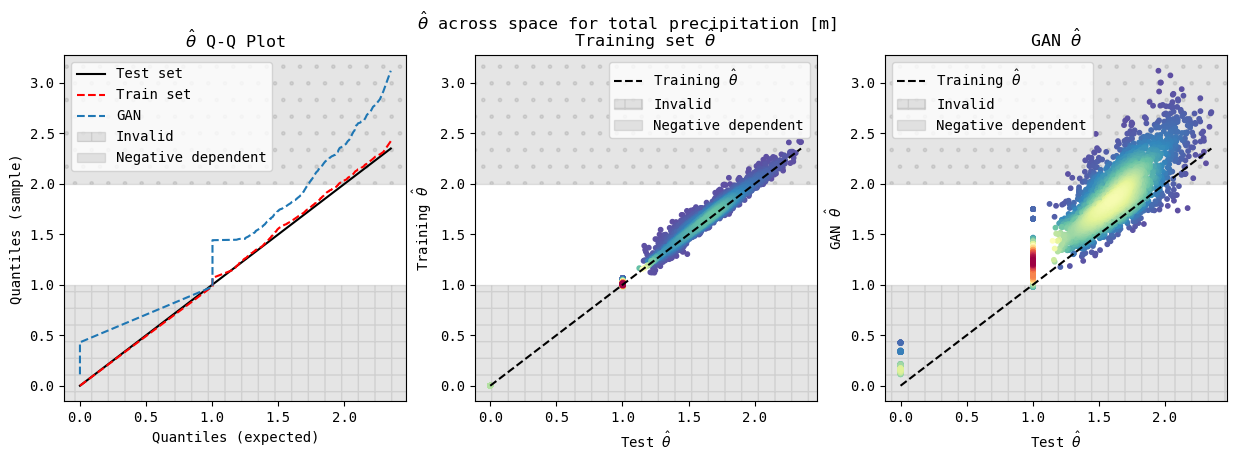

In [671]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))

# qq-plot
ax = axs[0]
quantiles = np.linspace(0, 1, 1000)
ax.plot(np.quantile(test_ecs, quantiles), np.quantile(test_ecs, quantiles), '-k', label='Test set')
ax.plot(np.quantile(test_ecs, quantiles), np.quantile(train_ecs, quantiles), '--r', label='Train set')
ax.plot(np.quantile(test_ecs, quantiles), np.quantile(gan_ecs, quantiles), '--', label='GAN')

ylim = ax.get_ylim()
ax.axhspan(ylim[0], 1, color='grey', alpha=0.2, label='Invalid', hatch='+', zorder=0)
ax.axhspan(2, ylim[1], color='grey', alpha=0.2, label='Negative dependent', hatch='.', zorder=0)    
ax.set_xlabel('Quantiles (expected)')
ax.set_ylabel('Quantiles (sample)')
ax.legend();
ax.set_ylim(ylim)
ax.set_title(r'$\hat \theta$ Q-Q Plot');

# scatterplots
axs = axs[1:]
viz_utils.scatter_density2(np.array(test_ecs), np.array(train_ecs), axs[0], cmap='Spectral_r')
viz_utils.scatter_density2(np.array(test_ecs), np.array(gan_ecs), axs[1], cmap='Spectral_r')

for ax in axs:
    ax.set_xlabel(r'Test $\hat \theta$')
    ax.plot(sorted(test_ecs), sorted(test_ecs), '--k', label=r'Training $\hat \theta$')
    
axs[0].set_title(r'Training set $\hat \theta$')
axs[1].set_title(r'GAN $\hat \theta$')

axs[0].set_ylabel(r'Training $\hat \theta$')
axs[1].set_ylabel(r'GAN $\hat \theta$');

for ax in axs:
    ax.axhspan(ylim[0], 1, color='grey', alpha=0.2, label='Invalid', hatch='+', zorder=0)
    ax.axhspan(2, ylim[1], color='grey', alpha=0.2, label='Negative dependent', hatch='.', zorder=0)   
    ax.set_ylim(ylim)
    ax.legend()

fig.suptitle(r"$\hat \theta$ across space for {}".format(viz_utils.channel_labels[channel]))
fig.savefig(os.path.join(figdir, f'ecoeff_distribution_{channel}.png'), dpi=300, bbox_inches='tight');

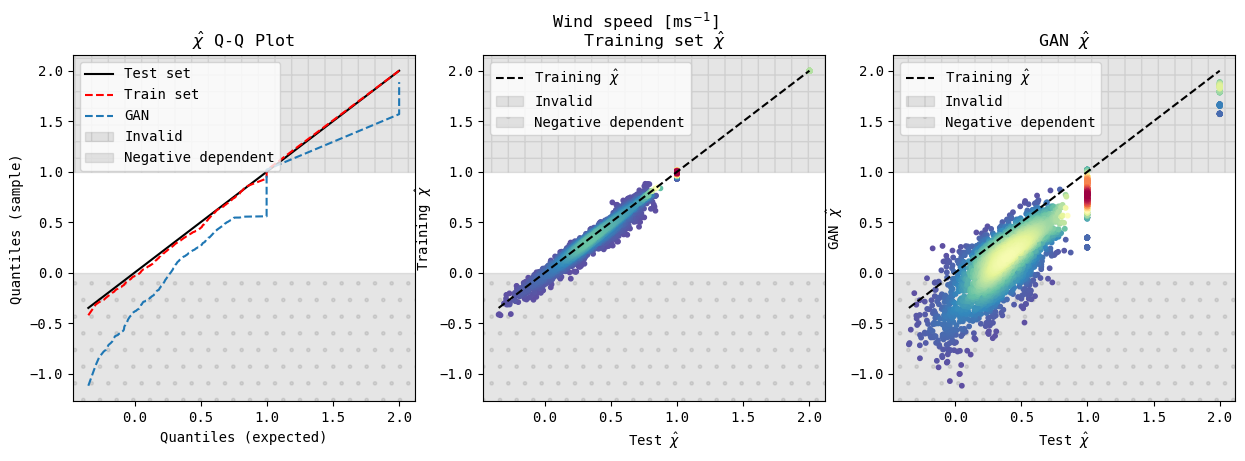

In [371]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4.5))

train_ecorrs = 2 - np.array(train_ecs)
test_ecorrs = 2 - np.array(test_ecs)
gan_ecorrs = 2 - np.array(gan_ecs)

# qq-plot
ax = axs[0]
quantiles = np.linspace(0, 1, 1000)
ax.plot(np.quantile(test_ecorrs, quantiles), np.quantile(test_ecorrs, quantiles), '-k', label='Test set')
ax.plot(np.quantile(test_ecorrs, quantiles), np.quantile(train_ecorrs, quantiles), '--r', label='Train set')
ax.plot(np.quantile(test_ecorrs, quantiles), np.quantile(gan_ecorrs, quantiles), '--', label='GAN')

ylim = ax.get_ylim()
ax.axhspan(1, ylim[1], color='grey', alpha=0.2, label='Invalid', hatch='+', zorder=0)
ax.axhspan(ylim[0], 0, color='grey', alpha=0.2, label='Negative dependent', hatch='.', zorder=0) 
ax.set_ylim(ylim)

ax.set_xlabel('Quantiles (expected)')
ax.set_ylabel('Quantiles (sample)')
ax.legend(loc='upper left');
ax.set_title(r'$\hat \chi$ Q-Q Plot');

# scatterplots
axs = axs[1:]
viz_utils.scatter_density2(np.array(test_ecorrs), np.array(train_ecorrs), axs[0], cmap='Spectral_r')
viz_utils.scatter_density2(np.array(test_ecorrs), np.array(gan_ecorrs), axs[1], cmap='Spectral_r')

for ax in axs:
    ax.set_xlabel(r'Test $\hat \chi$')
    ax.plot(sorted(test_ecorrs), sorted(test_ecorrs), '--k', label=r'Training $\hat \chi$')
    
axs[0].set_title(r'Training set $\hat \chi$')
axs[1].set_title(r'GAN $\hat \chi$')

axs[0].set_ylabel(r'Training $\hat \chi$')
axs[1].set_ylabel(r'GAN $\hat \chi$');

for ax in axs:
    ax.set_ylim(ylim)
    ax.axhspan(1, ylim[1], color='grey', alpha=0.2, label='Invalid', hatch='+', zorder=0)
    ax.axhspan(ylim[0], 0, color='grey', alpha=0.2, label='Negative dependent', hatch='.', zorder=0)
    ax.legend()

fig.suptitle(viz_utils.channel_labels[channel].capitalize())
fig.savefig(os.path.join(figdir, f'ecorr_distribution_{channel}.png'), dpi=300, bbox_inches='tight');

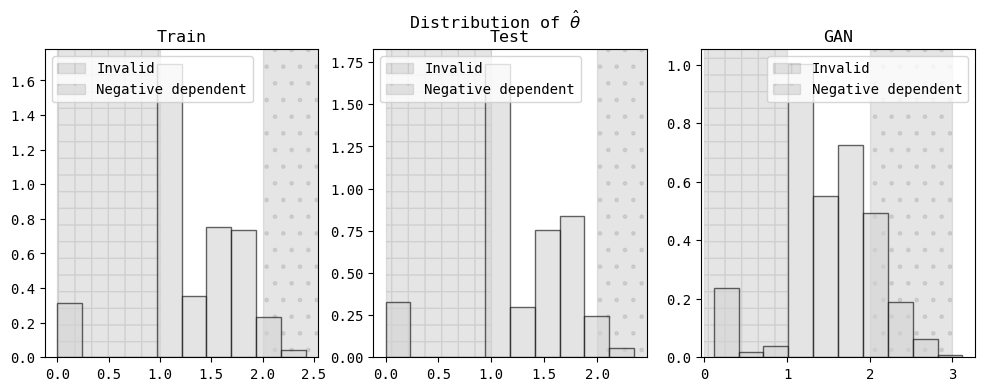

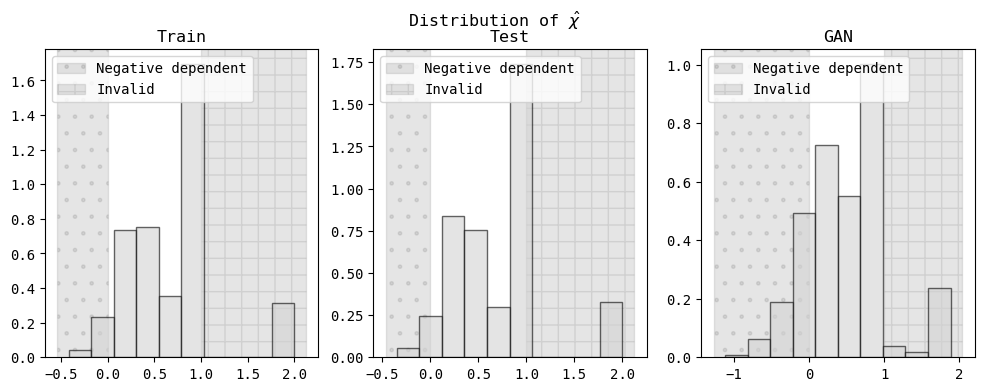

In [215]:
# distribution of ecs
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].hist(train_ecs, **hist_kwargs)
axs[1].hist(test_ecs, **hist_kwargs)
axs[2].hist(gan_ecs, **hist_kwargs);

axs[0].set_title('Train')
axs[1].set_title('Test')
axs[2].set_title('GAN')

for ax in axs:
    xlim = ax.get_xlim()
    ax.axvspan(0, 1, color='grey', alpha=0.2, label='Invalid', hatch='+', zorder=0)
    ax.axvspan(2, 3, color='grey', alpha=0.2, label='Negative dependent', hatch='.', zorder=0)
    ax.set_xlim(xlim)
    ax.legend()

fig.suptitle(r'Distribution of $\hat \theta$');

# correlations
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].hist(train_ecorrs, **hist_kwargs)
axs[1].hist(test_ecorrs, **hist_kwargs)
axs[2].hist(gan_ecorrs, **hist_kwargs);

axs[0].set_title('Train')
axs[1].set_title('Test')
axs[2].set_title('GAN')

for ax in axs:
    ax.axvspan(ax.get_xlim()[0], 0, color='grey', alpha=0.2, label='Negative dependent', hatch='.', zorder=0)
    ax.axvspan(1, ax.get_xlim()[1], color='grey', alpha=0.2, label='Invalid', hatch='+', zorder=0)
    ax.legend(loc='upper left')

fig.suptitle(r'Distribution of $\hat \chi$');



In [216]:
# plot
images = images.reshape(n, h * w, c)
images_test = images_test.reshape(images_test.shape[0], h * w, c)
gan_inv = gan_inv.reshape(gan.shape[0], h * w, c)

train_sub_one = {key: value for key, value in train_ecs_dict.items() if value < 1}
train_above_two  = {key: value for key, value in train_ecs_dict.items() if value > 2}

In [217]:
options = iter(train_sub_one.items())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Double-check EC: {(321, 113): 2.0785177}


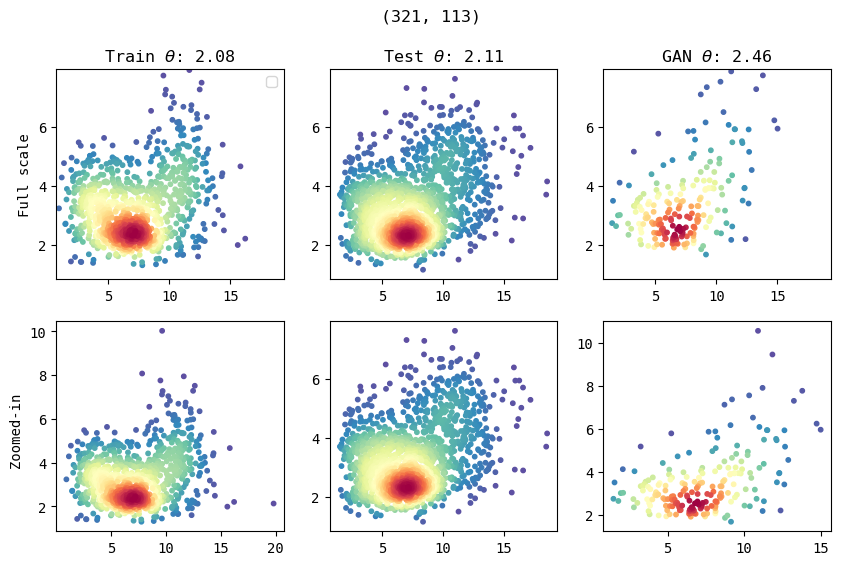

In [228]:
reload(viz_utils)
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

(i, j), theta = next(options)
i0, i1 = viz_utils.translate_indices(i)
j0, j1 = viz_utils.translate_indices(j)

if pot:
    thresh_i = thresholds[i0, i1, channel]
    thresh_j = thresholds[j0, j1, channel]

for row in range(2):
    viz_utils.scatter_density2(images[:, i, channel].transpose(), images[:, j, channel].transpose(), axs[row, 0], cmap="Spectral_r")
    viz_utils.scatter_density2(images_test[:, i, channel].transpose(), images_test[:, j, channel].transpose(), axs[row, 1], cmap="Spectral_r")
    viz_utils.scatter_density2(gan_inv[:, i, channel].transpose(), gan_inv[:, j, channel].transpose(), axs[row, 2], cmap="Spectral_r")

xlim = axs[0, 1].get_xlim()
ylim = axs[0, 1].get_ylim()

for ax in axs[0, :]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if pot:
        ax.axvline(thresh_i, linestyle='--', color='k', label='Threshold')
        ax.axhline(thresh_j, linestyle='--', color='k')
    
for ax in axs[1, :]:
    if pot:
        ax.set_xlim([thresh_i, xlim[1]])
        ax.set_ylim([thresh_j, ylim[1]])
    
axs[0, 0].legend()

axs[0, 0].set_title(r'Train $\theta$: {:.2f}'.format(theta))
axs[0, 1].set_title(r'Test $\theta$: {:.2f}'.format(test_ecs_dict[(i, j)]))
axs[0, 2].set_title(r'GAN $\theta$: {:.2f}'.format(gan_ecs_dict[(i, j)]));

axs[0, 0].set_ylabel('Full scale')
axs[1, 0].set_ylabel('Zoomed-in ')

fig.suptitle(f'({i}, {j})');

print('Double-check EC:', utils.get_extremal_coeffs(train, [j, i]))

In [221]:
options = iter(train_above_two.items())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Double-check EC: {(321, 41): 2.09497}


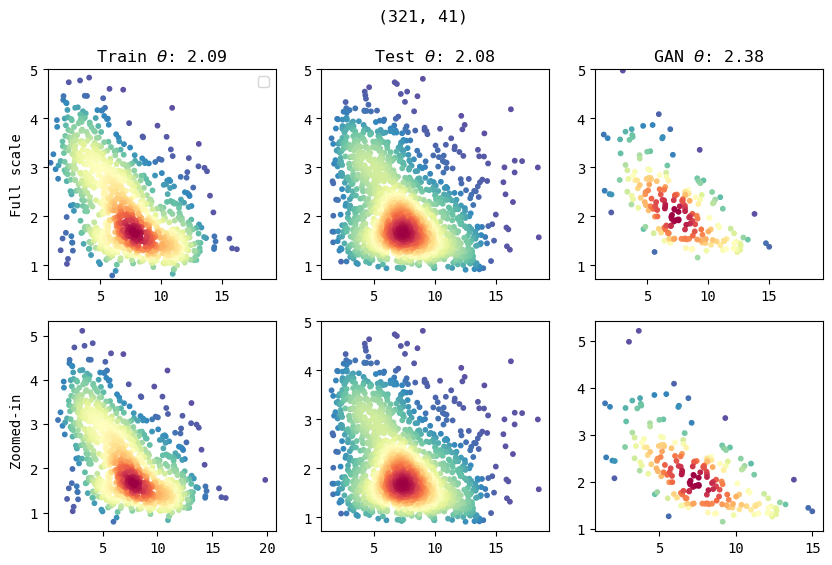

In [227]:
reload(viz_utils)
fig, axs = plt.subplots(2, 3, figsize=(10, 6))

(i, j), theta = next(options)
i0, i1 = viz_utils.translate_indices(i)
j0, j1 = viz_utils.translate_indices(j)

if pot:
    thresh_i = thresholds[i0, i1, channel]
    thresh_j = thresholds[j0, j1, channel]

for row in range(2):
    viz_utils.scatter_density2(images[:, i, channel].transpose(), images[:, j, channel].transpose(), axs[row, 0], cmap="Spectral_r")
    viz_utils.scatter_density2(images_test[:, i, channel].transpose(), images_test[:, j, channel].transpose(), axs[row, 1], cmap="Spectral_r")
    viz_utils.scatter_density2(gan_inv[:, i, channel].transpose(), gan_inv[:, j, channel].transpose(), axs[row, 2], cmap="Spectral_r")

xlim = axs[0, 1].get_xlim()
ylim = axs[0, 1].get_ylim()

for ax in axs[0, :]:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if pot:
        ax.axhline(thresh_j, linestyle='--', color='k', label='Threshold')
        ax.axvline(thresh_i, linestyle='--', color='k')
    
for ax in axs[1, :]:
    if pot:
        ax.set_xlim([thresh_i, xlim[1]])
        ax.set_ylim([thresh_j, ylim[1]])
    
axs[0, 0].legend()

axs[0, 0].set_title(r'Train $\theta$: {:.2f}'.format(theta))
axs[0, 1].set_title(r'Test $\theta$: {:.2f}'.format(test_ecs_dict[(i, j)]))
axs[0, 2].set_title(r'GAN $\theta$: {:.2f}'.format(gan_ecs_dict[(i, j)]));

axs[0, 0].set_ylabel('Full scale')
axs[1, 0].set_ylabel('Zoomed-in ')

fig.suptitle(f'({i}, {j})');

print('Double-check EC:', utils.get_extremal_coeffs(train, [j, i]))

## Heatmaps

In [672]:
# load data fresh
reload(utils)
gan = dcgan(1000)
train, _, params, images, thresholds = utils.load_training_data("/Users/alison/Documents/DPhil/multivariate", evt_type=evt_type)
test, *_ = utils.load_test_data("/Users/alison/Documents/DPhil/multivariate", evt_type=evt_type)

train = utils.tf_unpad(train, paddings).numpy()
test = utils.tf_unpad(test, paddings).numpy()
gan = utils.tf_unpad(gan, paddings).numpy()
gan = utils.gaussian_blur(gan, kernel_size=2, sigma=0.8).numpy()  # smoothing filter

if pot: f_thresholds = utils.interpolate_thresholds(thresholds, images, train)

n, h, w, c = train.shape
cmaps = ['YlOrRd', 'GnBu', "PuBu_r"]

train_inv = utils.inv_probability_integral_transform(train, images, train, params, evt_type, thresholds)
gan_inv = utils.inv_probability_integral_transform(gan, images, train, params, evt_type, thresholds)    

help(viz_utils.compare_ecs_plot)

Help on function compare_ecs_plot in module evtGAN.viz_utils:

compare_ecs_plot(train_marginals, test_marginals, fake_marginals, x, y, params=None, thresh=None, channel=0, cmap='cividis', inverse_transform=True)



In [673]:
# extreme sets
v = 0.95
etrain = train[np.amax(train, axis=(1, 2, 3)) > v, ...]
etest = test[np.amax(test, axis=(1, 2, 3)) > v, ...]
egan = gan[np.amax(gan, axis=(1, 2, 3)) > v, ...]

etrain_inv = utils.inv_probability_integral_transform(etrain, images, train, params, evt_type, thresholds)
etest_inv = utils.inv_probability_integral_transform(etest, images, train, params, evt_type, thresholds)
egan_inv = utils.inv_probability_integral_transform(egan, images, train, params, evt_type, thresholds)

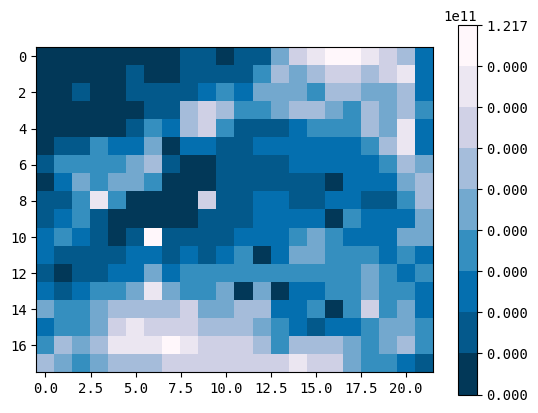

In [674]:
rain_params = params[..., 0, 2].ravel()

im = plt.imshow(egan_inv[0, ..., 2], cmap, norm) #cmap=cmap, norm=norm)
plt.colorbar(im)



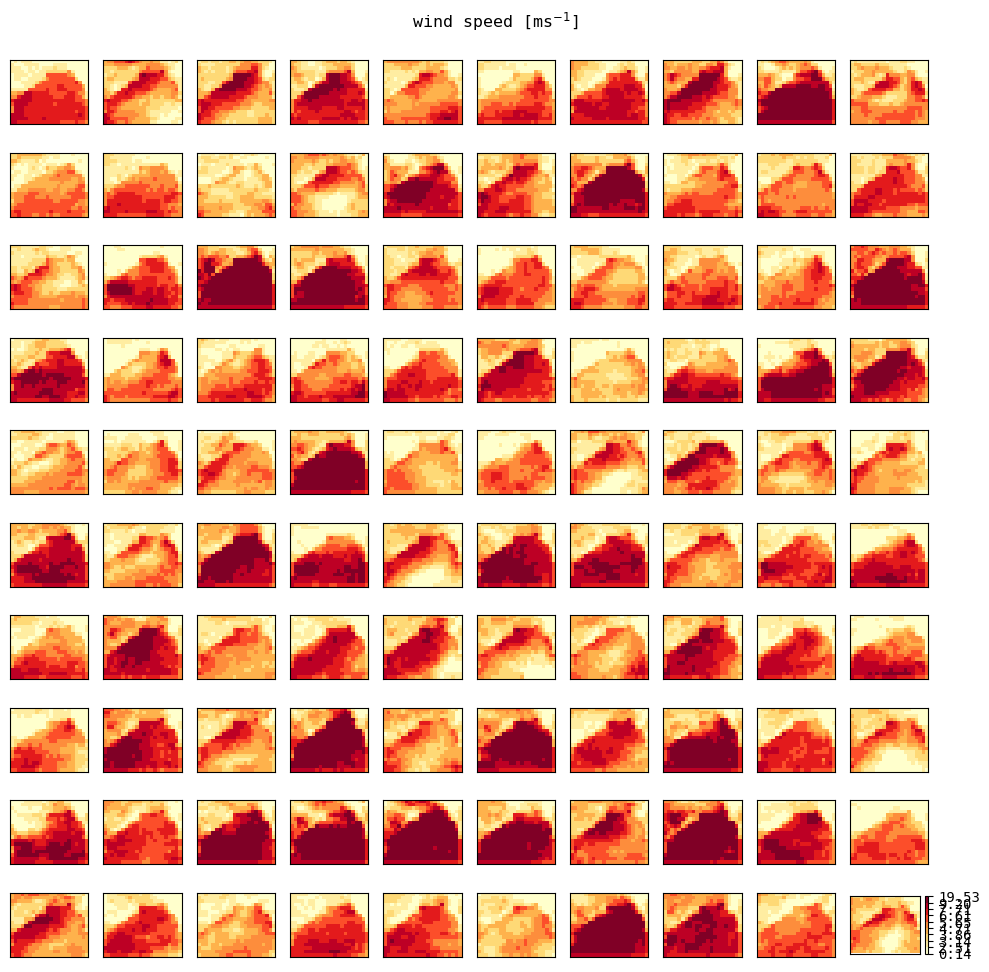

In [676]:
# single channel
reload(viz_utils)
data = gan_inv
channel = 0

cmap, norm = viz_utils.discrete_colormap(data[..., channel].ravel(), 10, 0, cmaps[channel], under='dimgrey')
fig = viz_utils.plot_one_hundred_images(data, channel=channel, suptitle=viz_utils.channel_labels[channel], cmap=cmap, norm=norm)

# fig.savefig(os.path.join(figdir, 'temp', f'training_data_{channel}.png'), **plot_kwargs)

In [ ]:
# to understand why some precipitation values are negative
from scipy.stats import genextreme

x = sorted(egan_inv[:, 0, 4, 2])
plt.hist(x, bins=20, **hist_kwargs);
plt.plot(x, genextreme.pdf(x, *params[0, 4, :, 2]))

#### Plot 100 images: train/test...marginals/full scale

In [238]:
figdir

'/Users/alison/Documents/DPhil/multivariate/cycloneGAN/figures/results'

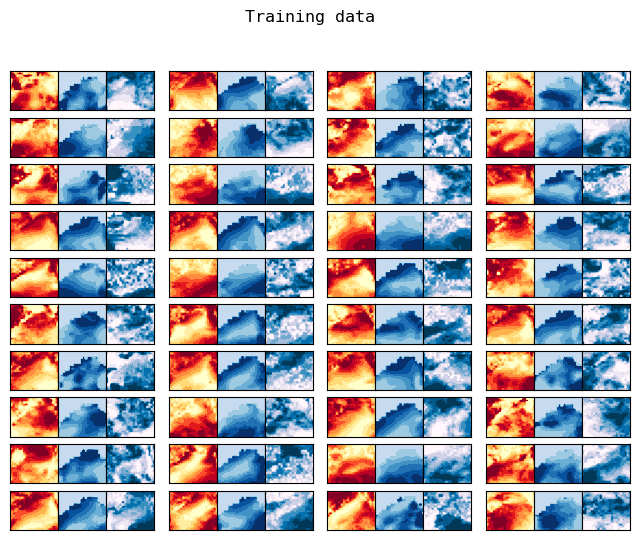

In [734]:
reload(viz_utils)
cmaps = ['YlOrRd', 'Blues', 'PuBu'] #'GnBu', 'PuBu']


import matplotlib.pyplot as plt
import numpy as np

data = train

fig = plt.figure(figsize=(8, 6))
outer_grid = fig.add_gridspec(10, 4, hspace=0.1, wspace=0.1)

for i, grid in enumerate(outer_grid):
        inner_grid = grid.subgridspec(1, 3, wspace=0)
        axs = inner_grid.subplots()  # Create all subplots for the inner grid.
        
        for j, ax in enumerate(axs):
            cmap, norm = viz_utils.discrete_colormap(data[i, ..., j], 10, 0, cmaps[j], under='lightgrey')
            ax.imshow(data[i, ..., j], cmap=cmap, norm=norm)
            ax.set(xticks=[], yticks=[])
            ax.label_outer()
        
for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle('Training data');
fig.savefig(os.path.join(figdir, 'train_data.png'), **plot_kwargs)

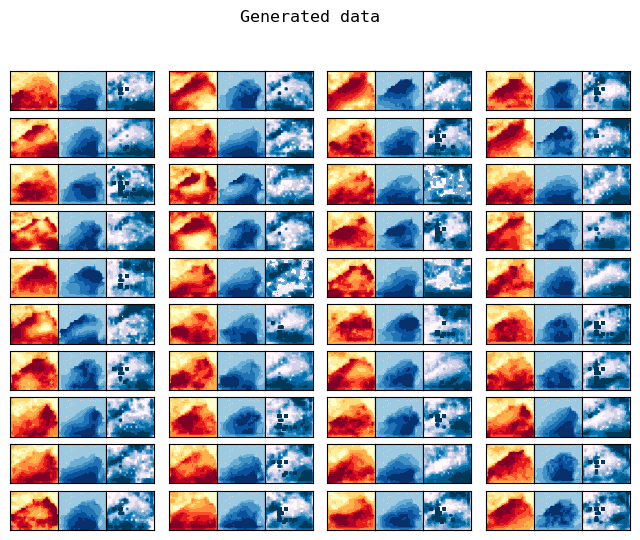

In [733]:
reload(viz_utils)
cmaps = ['YlOrRd', 'Blues', 'PuBu'] #'GnBu', 'PuBu']


import matplotlib.pyplot as plt
import numpy as np

data = gan_inv

fig = plt.figure(figsize=(8, 6))
outer_grid = fig.add_gridspec(10, 4, hspace=0.1, wspace=0.1)

for i, grid in enumerate(outer_grid):
        inner_grid = grid.subgridspec(1, 3, wspace=0)
        axs = inner_grid.subplots()  # Create all subplots for the inner grid.
        
        for j, ax in enumerate(axs):
            cmap, norm = viz_utils.discrete_colormap(data[i, ..., j], 10, 0, cmaps[j], under='lightgrey')
            x = data[i, ..., j]
            x[x < 0] = 0
            ax.imshow(x, cmap=cmap, norm=norm)
            ax.set(xticks=[], yticks=[])
            ax.label_outer()
        
for ax in fig.get_axes():
    ax.label_outer()

fig.suptitle('Generated data');
fig.savefig(os.path.join(figdir, 'generated_data.png'), **plot_kwargs)